In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
from scipy import stats

In [3]:
from scipy.ndimage import measurements
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from cartopy import crs as ccrs # Cartography library

import cartopy.feature as cfeature


In [4]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="64GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.121.4/3882334/1' processes=1 threads=256, memory=59.60 GiB>

### Defining functions

In [6]:
def time_mean_model(file,times,var,lat,lon,environ):
    ## Funtion to calculate the monthly mean of precipitation from the model
    ### the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    dset = xr.open_mfdataset(file, engine='netcdf4', combine='by_coords',chunks=({'time':20})).sel(
        time=slice(times[0],times[1]))
    if environ is 'trop':
        pr=dset[var].sel(
            time=slice(times[0],times[1])).sel(
            lat=slice(lt[0],lat[1]),lon=slice(lon[0],lon[1])).resample(time='1MS').mean(dim=('time'),skipna=True)
    else:
        lsmask01 = land_sea_mask(dset)
        if environ is 'ocean':
            pr=dset[var].where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        elif environ is 'land':
            pr=dset[var].where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        else:
            return print('no correct environment')
    jobs = dask.persist(pr)
    varf = dask.compute(pr)[0]
    pr_mon = varf.groupby('time.month').mean()
    return pr_mon*3600*24

In [7]:
def time_mean_imerg_multi(file,lon,lat,environ):
    ##Funtion to calculate the climatology monthly mean of precipitation from IMERG
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    data = xr.open_mfdataset(
        file, combine='by_coords',engine='netcdf4',chunks=({'time':20}))['calibrated_precipitation']
    if environ is 'trop':
        pr=data.sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
    else:
        lsmask01 = land_sea_mask(data)
        if environ is 'ocean':
            pr=data.where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        elif environ is 'land':
            pr=data.where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        else:
            return print('Something is wrong')
    
    prmon = pr.resample(time='1MS').mean(dim='time')
    prmon_clim = prmon.groupby('time.month').mean(dim='time')
    
    jobs = dask.persist(prmon_clim)
    progress(jobs, notebook=False)
    precip = dask.compute(prmon_clim)
    
    return precip[0]

In [ ]:
def land_sea_mask(dset):
    ##This function calculate the land_sea mask according to the resolution of the data##
    ###negative values is ocean, positive values is land
    filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
    dsetmask = xr.open_dataset(filemask)
    lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset.lon.values,lat=dset.lat.values,method='linear') *0 +2
    lsmask01 = lsmask01.where(lsmask01==2,-2)
    return lsmask01

**Function to calculate object detection**

In [1]:
def calc_area(data,dx,dy):
    ##Calculate the area of each grid cell in the data
    earthr = 6.371e6
    loncmorph,latcmorph = np.meshgrid(data.lon.values,data.lat.values)
    area = xr.DataArray(data = (dx/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(dy/180*np.pi)*earthr,
                            dims=["lat","lon"],
                            coords=dict(
                            lat=(["lat"],data.lat.values),
                            lon=(["lon"],data.lon.values),))
    return area

In [2]:
def calc_objects(data,threshold,structure):
    ## This function calculates the objects of precipitation according to a threshold and a strcuture
    labels,num = measurements.label(data.where(data>threshold,0),structure=structure)
    ###sorting labels according to index
    labelsu = np.unique(labels);
    labels_n = np.searchsorted(labelsu,labels); 
    indices_n = np.arange(np.max(labels_n)+1);
    return labels_n,indices_n

In [3]:
def cal_statistic(data,area_grid,labels_n,indices_n,threshold):
    ## This function calculates the statistics of the objects as: 
        ##area 
        ##mean precipitation
        ##centroid (longitude and latitude)
    sum_area=ndimage.sum(area_grid,labels_n,indices_n)
    meanp = ndimage.mean((data).where(data>threshold,0),labels_n,indices_n)
    meanp_area = (ndimage.mean(data,labels_n,indices_n)/(ndimage.sum(area_grid,labels_n,indices_n)))
    centr_lat = [data.lat.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][0])] for j in range(
        len(indices_n))]
    centr_lon = [data.lon.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][1])] for j in range(
        len(indices_n))]
    
    stats  = np.zeros((5,len(indices_n)))
    stats[0,:] = sum_area
    stats[1,:] = meanp
    stats[2,:] = meanp_area
    stats[3,:] = centr_lat
    stats[4,:] = centr_lon
    
    return meanp, sum_area, stats

In [4]:
def cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min):
    ##This function caluclates the object with the maximum area 
    sel_ind = indices_n[(meanp>threshold) & (sum_area/1000000>(area_min))]
    nstats = [stats[:,indices_n==sel_ind[i]] for i in range(len(sel_ind))]
    nlabel = [np.where(labels_n==sel_ind[i], data, np.nan) for i in range(len(sel_ind))]
    
    if not sel_ind.any():
        nstats = [np.zeros((5,1))*np.nan]
        return nstats,nlabel
    elif len(sel_ind) == 1:
        return nstats,nlabel
    else:
        area = [nstats[i][0] for i in range(len(sel_ind))]
        max_tuple = max(area, key=lambda x:x[0])
        max_ind = area.index(max_tuple)

        return [nstats[max_ind]], [nlabel[max_ind]]

In [5]:
def object_id(data,dx,dy,structure,threshold,area_min):
    ####create area
    area_grid = calc_area(data,dx,dy) 
    ###calculating objects
    labels_n,indices_n = calc_objects(data,threshold,structure)
    
    ###calculate stats
    meanp, sum_area, stats = cal_statistic(data,area_grid,labels_n,indices_n,threshold)

    ###selecting only the according to the classification 
    return cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min)

_Adding new color bar_

In [13]:
GnBu = cm.get_cmap('GnBu', 128)
newcolors = GnBu(np.linspace(0, 1, 128))
white = np.array([1, 1, 1, 1])
newcolors[0:12, :] = white
blue = np.array([0.11, 0.11, 0.5, 1])
newcolors[120:124, :] = blue
black = np.array([0, 0, 0, 1])
newcolors[124:128, :] = black
GnBu_mod = ListedColormap(newcolors)

In [14]:
GnBu2 = cm.get_cmap('YlGnBu', 12)
newcolors2 = GnBu2(np.linspace(0, 1, 12))
white = np.array([1, 1, 1, 1])
scnd = np.array([0.89051745, 0.76469402, 0.71028506 , 1])
newcolors2[0, :] = white
newcolors2[1, :] = scnd
clevs = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25,
         30, 35]
GnBu_mod2 = ListedColormap(newcolors2,'precip')
GnBu_mod2_norm = BoundaryNorm(clevs,GnBu_mod2.N)

*********

**List files of interpolated data**

In [15]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'pr_dpp0066_daily'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of IMERG**

In [16]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

### Results

**Calculate monthly mean precipitation**

_ICON-S_

In [17]:
times = ['2020-02-01','2021-01-31']
var = 'pr'
pr_land = time_mean_model(file_dpp0066pp,times,var,[-30,30],[-180,180],'land')

_Climatology of IMERG_

In [18]:
imerg_mult_land_int = time_mean_imerg_multi(file_imerg,\
                                                                    [-180,180],[-30,30],'land')

In [19]:
fig = plt.figure(figsize=(13, 4))
ax1=fig.add_axes([0.2,0.15,0.6,0.05])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
plot = pr_land.sel(month=4).plot(levels = clevs,cmap=GnBu_mod2,norm=GnBu_mod2_norm, 
                          transform=ccrs.PlateCarree(),add_colorbar=False)
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-180, 179.9, -30, 30], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,31,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-180,179,60),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(None)
cb1 = plt.colorbar(plot,extend='max',orientation='horizontal',cax=ax1,shrink=0.8,pad=0.09)
cb1.ax.set_xlabel('Precipitation / mm day$^{-1}$',fontsize=12)
cb1.ax.tick_params(labelsize=12)
plt.savefig('/scratch/m/m300876/results/precip_paper/step_1_object_detection.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


**Calculate the percentile 80 over the land**

In [19]:
pr_land_q80 = pr_land.quantile(0.8,dim=('lon','lat'))

In [20]:
pr_imerg_land_q80 = imerg_mult_land_int.quantile(0.8,dim=('lon','lat'))

In [21]:
pr_land_q80.sel(month=4).values

array(6.16030312)

In [38]:
fig = plt.figure(figsize=(13, 4))
ax1=fig.add_axes([0.2,0.15,0.6,0.05])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
plot = pr_land.sel(month=4).where(
    pr_land.sel(month=4)>=pr_land_q80.sel(month=4).values).plot(levels = clevs,cmap=GnBu_mod2,norm=GnBu_mod2_norm, 
                          transform=ccrs.PlateCarree(),add_colorbar=False)
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-180, 179.9, -30, 30], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,31,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-180,179,60),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(None)
cb1 = plt.colorbar(plot,extend='max',orientation='horizontal',cax=ax1,shrink=0.8,pad=0.09)
cb1.ax.set_xlabel('Precipitation / mm day$^{-1}$',fontsize=12)
cb1.ax.tick_params(labelsize=12)
plt.savefig('/scratch/m/m300876/results/precip_paper/step_2_object_detection.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


**Masking precipitation using the percentile over south America**

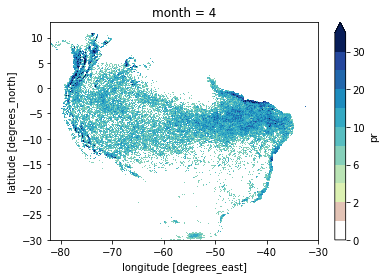

In [23]:
pr_land.sel(month=4).where(
    pr_land.sel(month=4)>=pr_land_q80.sel(month=4).values).sel(
    lat=slice(-30,13),lon=slice(-82,-30)).plot.pcolormesh(levels = clevs,cmap=GnBu_mod2,norm=GnBu_mod2_norm)

In [38]:
fig = plt.figure(figsize=(13, 6))
ax1=fig.add_axes([0.75,0.2,0.02,0.6])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
plot= plt.pcolor(pr_land.sel(lon=slice(-82,-30)).lon,pr_land.sel(lat=slice(-30,13)).lat
           ,pr_land.sel(month=4).where(
    pr_land.sel(month=4)>=pr_land_q80.sel(month=4).values).sel(
    lat=slice(-30,13),lon=slice(-82,-30)).data,cmap=GnBu_mod2,norm=GnBu_mod2_norm,transform=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,15,10),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-80,-28,20),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(None)
cb1 = plt.colorbar(plot,extend='max',orientation='vertical',cax=ax1,shrink=0.8,pad=0.09)
cb1.ax.set_ylabel('Precipitation / mm day$^{-1}$',fontsize=12)
cb1.ax.tick_params(labelsize=18)
ax.coastlines(resolution='110m',linewidth=0.6)

plt.savefig('/scratch/m/m300876/results/precip_paper/step_3_object_detection.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


**Converting nan values to zero to use in the object detection**

In [22]:
pr2_land = pr_land.where(pr_land>=0,0)

In [23]:
pr2_imerg_land = imerg_mult_land_int.where(imerg_mult_land_int[0]>=0,0)

**Choose the structure to use in the object detection**\\
see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html

In [24]:
s = ndimage.generate_binary_structure(2,2)

**South America**

_******Identify the biggest object_

In [25]:
##ICON-S
sam_stats =  [object_id(pr2_land[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_land_q80[i].values,[500*500]) for i in range(pr_land_q80.size)]

_**Getting the area_

In [26]:
sam_area = [sam_stats[i][0][0][0] for i in range(pr_land_q80.size)]

_**Getting the longitude of the centroid_

In [27]:
sam_loni = [sam_stats[i][0][0][-1] for i in range(pr_land_q80.size)]

_**Getting the latitude of the centroid_

In [28]:
sam_lati = [sam_stats[i][0][0][-2] for i in range(pr_land_q80.size)]

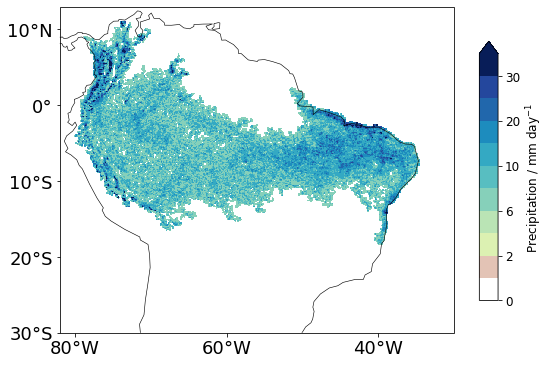

In [36]:
fig = plt.figure(figsize=(13, 6))
ax1=fig.add_axes([0.75,0.2,0.02,0.6])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
plot= plt.pcolor(pr_land.sel(lon=slice(-82,-30)).lon,pr_land.sel(lat=slice(-30,13)).lat,
           sam_stats[3][1][0],cmap=GnBu_mod2,norm=GnBu_mod2_norm,transform=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,15,10),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-80,-28,20),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(None)
cb1 = plt.colorbar(plot,extend='max',orientation='vertical',cax=ax1,shrink=0.8,pad=0.09)
cb1.ax.set_ylabel('Precipitation / mm day$^{-1}$',fontsize=12)
cb1.ax.tick_params(labelsize=12)
ax.coastlines(resolution='110m',linewidth=0.6)

plt.savefig('/scratch/m/m300876/results/precip_paper/step_4_object_detection.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


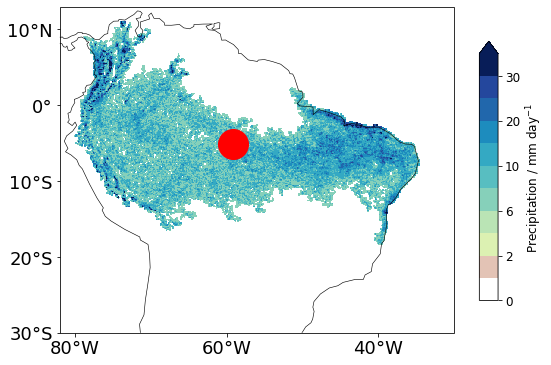

In [37]:
fig = plt.figure(figsize=(13, 6))
ax1=fig.add_axes([0.75,0.2,0.02,0.6])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
plot= plt.pcolor(pr_land.sel(lon=slice(-82,-30)).lon,pr_land.sel(lat=slice(-30,13)).lat,
           sam_stats[3][1][0],cmap=GnBu_mod2,norm=GnBu_mod2_norm,transform=ccrs.PlateCarree())
ax.set_yticks(np.arange(-30,15,10),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-80,-28,20),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(None)
cb1 = plt.colorbar(plot,extend='max',orientation='vertical',cax=ax1,shrink=0.8,pad=0.09)
cb1.ax.set_ylabel('Precipitation / mm day$^{-1}$',fontsize=12)
cb1.ax.tick_params(labelsize=12)
ax.coastlines(resolution='110m',linewidth=0.6)

plt.plot(sam_loni[3],sam_lati[3],'or',markersize=30,transform=ccrs.PlateCarree())
plt.savefig('/scratch/m/m300876/results/precip_paper/step_5_object_detection.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})
